此文件旨在选择合适的特征组合作为模型输入。<br>
模型：回归决策树 <br>
输入时长:6小时 <br>
待选特征：PM2.5、本地点6特征、本地点PCA、所有地点6特征

In [1]:
import pandas as pd
import numpy as np
import os 
import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix

from multiprocessing import Pool

import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings 
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams[u'font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
# 改变此处time_in 即可改变输入时间长度
def data_generate(data_type_filled):
    time_in = 6
    time_out = 6

    num_sample = data_type_filled['PM2.5'].shape[0] -time_in -time_out
    num_loc = data_type_filled['PM2.5'].shape[1] -3
        
    num_feature = len(data_type_filled)
    data = []
    label = []
    data_filled_array = {}
    for type_now in data_type_filled:
        data_filled_array[type_now] = data_type_filled[type_now].iloc[:,3:].values
        
    start = time.time()
    for i in range(0,num_sample):
        data_now = np.zeros([time_in, num_feature, num_loc])
#         data_now = np.zeros([time_in, num_feature-1, num_loc]) #舍去PM2.5 or PCA
        feature_now = -1
        

        # 判断date是否连续
        if data_type_filled['PM2.5'].iloc[i+time_in+time_out-1,0] - data_type_filled['PM2.5'].iloc[i,0] < 2:
            # 判断hour是否连续
            if data_type_filled['PM2.5'].iloc[i+time_in+time_out-1,1] == (data_type_filled['PM2.5'].iloc[i,1] + time_in+time_out-1)%24: 
                for type_now in data_type_filled:
#                     if type_now == 'PCA': #选择只要PCA特征
#                     if type_now == 'PM2.5': #选择只要PM2.5特征
                    feature_now = feature_now +1
                    data_now[:,feature_now,:] = data_filled_array[type_now][i:i+time_in,:].copy()
                    if type_now == 'PM2.5':
                        label_now = data_filled_array[type_now][i+time_in:i+time_in+time_out,:].copy()
#                         label_now[label_now < 35] = 1
#                         label_now[label_now > 250] = 6
#                         label_now[label_now > 150] = 5
#                         label_now[label_now > 115] = 4
#                         label_now[label_now > 75] = 3
#                         label_now[label_now > 35] = 2
                        
                data_now = data_now.reshape((time_in*num_feature,num_loc))
#                 data_now = data_now.reshape((time_in*(num_feature-1),num_loc)) #舍去PM2.5 or PCA
                data.append(data_now)
                label.append(label_now)
        
    end = time.time()
#     print('data generating lasted: '+str(end-start))
           
    data = np.array(data)
    label = np.array(label)
    if label[label==0].shape[0]>0:
        print('there is a bug')
    return data, label

In [3]:
def data_split(loc):
    print(loc)
    # 读取数据
    data_all = pd.read_csv('.././data_mix_clean/'+loc+'.csv')
#     data_all = pd.read_csv('.././data_mix_clean_pca/'+loc+'.csv')
    data_all = data_all.iloc[:,1:]
    # 划分数据集
    data_train = data_all[data_all['date'] < 20200000]
    data_train = data_train[data_train['date'] > 20150000]
    data_val = data_all[data_all['date'] > 20200000]
    data_test = data_all[data_all['date'] < 20150000]
    # 制作时序数据集
    list_type = np.unique(data_all['type']).tolist()
    data_train_type = {}
    data_val_type = {}
    data_test_type = {}
    for data_type in list_type:
        data_train_type[data_type] = data_train[data_train['type']==data_type]
        data_val_type[data_type] = data_val[data_val['type']==data_type]
        data_test_type[data_type] = data_test[data_test['type']==data_type]

    train_data,train_label = data_generate(data_train_type)
    val_data,val_label = data_generate(data_val_type)
    test_data,test_label = data_generate(data_test_type)
    
    return [train_data,train_label,val_data,val_label,test_data,test_label,loc]

In [4]:
list_loc = np.load(".././location.npy",allow_pickle=True)
MultiNum = 17
pool = Pool(processes=MultiNum)
dataset_splited_list = pool.map(data_split,list_loc)
pool.close()
pool.join()

云岗
万柳
丰台花园
官园
古城
东四
万寿西宫
大兴
北部新区
农展馆
房山
顺义
奥体中心
天坛
通州
亦庄
昌平
门头沟
平谷
怀柔
密云
延庆
定陵
八达岭
密云水库
东高村
永乐店
榆垡
琉璃河
前门
永定门内
西直门北
南三环
东四环


In [5]:
# 检查数据格式
print(dataset_splited_list[0][0].shape)
print(dataset_splited_list[0][1].shape)
# for i in range(8):
#     item = dataset_splited_list[0][1][dataset_splited_list[0][1]==i].shape[0]
#     num_all = dataset_splited_list[0][1].shape[0] * dataset_splited_list[0][1].shape[1]
#     print('ratio of '+str(i)+': '+str(item/num_all))

(34695, 36, 1)
(34695, 6, 1)


In [57]:
def para_pass(args):
    return train_pre(*args)

def train_pre(train_data,train_label,val_data,val_label,test_data,test_label,loc, model_name):
    # 训练模型
    print(model_name+' '+loc)
    train_predict = np.zeros(train_label.shape)
    val_predict = np.zeros(val_label.shape)
    test_predict = np.zeros(test_label.shape)

    for ti in range(train_label.shape[1]):
        if model_name =='DT':
            model = DecisionTreeRegressor(max_depth = 10)
#             model = DecisionTreeClassifier(max_depth = 20)
#             model = DecisionTreeClassifier(max_depth = 50, class_weight='balanced')
        elif model_name =='RF':
            model = RandomForestRegressor(n_estimators=10,max_depth = 30,max_features='auto')
#             model = RandomForestClassifier(n_estimators=50,max_depth = 50)
        elif model_name =='Ada_DT':
#             model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=50),n_estimators=50)
            model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=50),n_estimators=50)
        elif model_name =='GBDT':
            model = GradientBoostingRegressor(n_estimators=10,max_depth = 50)

        lo = 0
        model.fit(train_data[:,:,lo], train_label[:,ti,lo])
        train_predict[:,ti,lo] = model.predict(train_data[:,:,lo])
        val_predict[:,ti,lo] = model.predict(val_data[:,:,lo])
        test_predict[:,ti,lo] = model.predict(test_data[:,:,lo])
        
#         print(model.get_depth())
            
    return [train_predict,val_predict,test_predict,loc]

In [58]:
models = ['RF']
result_models = {}

MultiNum = 17
pool = Pool(processes=MultiNum)

for model_name in models:
    start = time.time()
    para_list = []
    for train_data,train_label,val_data,val_label,test_data,test_label,loc in dataset_splited_list:
        para_list.append([train_data,train_label,val_data,val_label,test_data,test_label,loc,model_name])
    result_pre_list = pool.map(para_pass,para_list)
    result_models[model_name] = result_pre_list

    end = time.time()
    print('training lasted: '+str(end-start))
pool.close() 
pool.join()

RF 东四
RF 天坛
RF 官园
RF 万寿西宫
RF 奥体中心
RF 农展馆
RF 万柳
RF 北部新区
RF 丰台花园
RF 云岗
RF 古城
RF 房山
RF 大兴
RF 亦庄
RF 通州
RF 顺义
RF 昌平
RF 门头沟
RF 平谷
RF 怀柔
RF 密云
RF 延庆
RF 定陵
RF 八达岭
RF 密云水库
RF 东高村
RF 永乐店
RF 榆垡
RF 琉璃河
RF 前门
RF 永定门内
RF 西直门北
RF 南三环
RF 东四环
training lasted: 127.13818550109863


In [59]:
def Evaluation(label, predict):
    MAE = np.mean(np.abs(label - predict))
    RMSE = np.power(np.mean(np.power(label - predict,2)) ,0.5)

    label_grade = label.copy()
    label_grade[label_grade < 35] = 1
    label_grade[label_grade > 250] = 6
    label_grade[label_grade > 150] = 5
    label_grade[label_grade > 115] = 4
    label_grade[label_grade > 75] = 3
    label_grade[label_grade > 35] = 2
    
    predict_grade = predict.copy()
    predict_grade[predict_grade < 35] = 1
    predict_grade[predict_grade > 250] = 6
    predict_grade[predict_grade > 150] = 5
    predict_grade[predict_grade > 115] = 4
    predict_grade[predict_grade > 75] = 3
    predict_grade[predict_grade > 35] = 2
    
    res = np.zeros(label_grade.shape)
    res[label_grade == predict_grade] = 1
    num_cor = res.sum()
    num_all = res.shape[0] * res.shape[1]
    prec = num_cor/num_all
    return MAE,RMSE,prec

In [60]:
for model_name in models:
    MAE = np.zeros([3,len(result_models[model_name]),6])
    RMSE = np.zeros([3,len(result_models[model_name]),6])
    PREC = np.zeros([3,len(result_models[model_name]),6])
    for ti in range(6):
        for train_predict,val_predict,test_predict,loc_pre in result_models[model_name]:
            idx_loc = list_loc.tolist().index(loc_pre)
            for _,train_label,_,val_label,_,test_label,loc_label in dataset_splited_list:
                if loc_pre == loc_label:
                    MAE[0,idx_loc,ti], RMSE[0,idx_loc,ti],PREC[0,idx_loc,ti]= Evaluation(train_label[:,ti,:],train_predict[:,ti,:])
                    MAE[1,idx_loc,ti], RMSE[1,idx_loc,ti],PREC[1,idx_loc,ti]= Evaluation(val_label[:,ti,:],val_predict[:,ti,:])
                    MAE[2,idx_loc,ti], RMSE[2,idx_loc,ti],PREC[2,idx_loc,ti]= Evaluation(test_label[:,ti,:],test_predict[:,ti,:])
    
#     np.save('../results/1_choosing_feature_'+'6loc_'+model_name+'.npy',PREC)

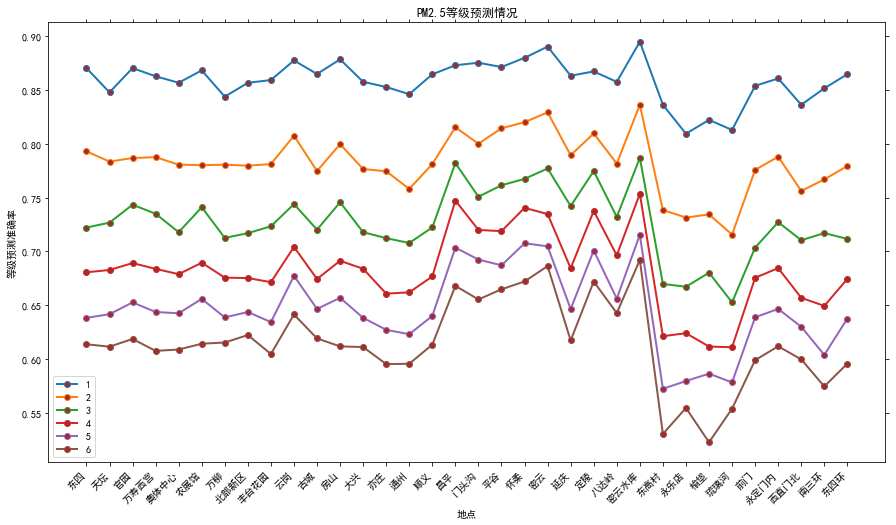

In [63]:
fig = plt.figure(figsize = (15,9))
plt.plot(list_loc, # x轴数据
         PREC[1,:,:], # y轴数据
         linestyle = '-', # 折线类型
         linewidth = 2, # 折线宽度
#          color = 'steelblue', # 折线颜色
         marker = 'o', # 点的形状
         markersize = 6, # 点的大小
#          markeredgecolor='black', # 点的边框色
         markerfacecolor='brown') # 点的填充色
plt.title('PM2.5等级预测情况')
plt.xlabel('地点')
plt.ylabel('等级预测准确率')
plt.tick_params(top = 'off', right = 'off')
fig.autofmt_xdate(rotation = 45)
# 设置图例
plt.legend([1,2,3,4,5,6])
# 显示图形
plt.show()